<a href="https://colab.research.google.com/github/Traintain/prediccion_analisis_de_marcha/blob/main/Proyecto_an%C3%A1lisis_de_marcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Importación de librerías

In [ ]:
import pandas as pd

# Seaborn
import seaborn as sns

# Librerías para la visualización
import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

#Scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Importar/ Exportar modelos
from joblib import dump, load

# 1.Entendimiento del negocio

Como parte del proceso diagnóstico de enfermedades que afecten la marcha se realizan laboratorios de marcha. En estos laboratorios se cuantifica y analiza cómo camina una persona. Dependiendo de esto un médico analiza los datos y da un concepto.

En este caso, nos interesa analizar las siguientes variables de los laboratorios de marcha:
- Edad del paciente
- Tipo: Puede ser espástica, diskinética, mixta, atáxica e hiptónica. La más común es espástica.
- Tono gastrocnemios: se tiene una medida basada en la escala de Ashworth para medir espacticidas. Esta indica que tanto puedes doblar la pierna hasta que se frena (doblez de la pierna). Es un valor entre 0 y 4, donde 0 indica movimiento normal y 4 indica que no se puede mover.
- Dorsiflexión plantar: cuánto dobla el tobillo para arriba en el examen físco (experto dice que es fundamental). va de -26 a 42 (mínimo 10 se considera normal). Puede haber negativos. ángulo, en grados
- Felxion plantar de tobillo: cuanti puede hacia abajo. Lo usual en espacidad es que sea positivo. 
- Silverskiöld: si se dobla diferente con la rodilla estirada y con la roilla doblada. (están cortos sólo los gemelos o el gemelo y el soleo). Booleana + no evaluable -> 4 categirías. Negativo == 0 Leve==1, Positivo==2 NE==3

Con esto se procedió a entrenar dos clasificadores: uno capaz de identificar si la persona necesita cirugía y otro que identifica el tipo de cirugía entre dos categorías:
- Alargar el tendón de aquiles
- Alargar los gemelos

# 1.Pre-procesamiento de los datos
Se tienen dos bases de datos separadas, una con las medidas de los análisis de marcha por paciente y otra con las etiquetas de las cirugías por paciente. Se generara una base de datos por

In [ ]:
# Carga de los archivos xlsx a pandas
analisisMarcha=pd.read_excel('Final_BD.xlsx')
etiquetas=pd.read_excel('Final_Etiquetas.xlsx')

In [ ]:
analisisMarcha.head()

,Unnamed: 0,Historia clinica,Distribucion,Edad,Tipo,Tono gastrocnemios derechos,Tono gastrocnemios izquierdos,Dorsiflexión derecha,Dorsiflexión izquierda,Flexión Plantar Tobillo Der,Flexión Plantar Tobillo Izq,Silfverskiöld derecha,Silfverskiöld izquierda,Cirugia derecha,Cirugia izquierda
0,1652,164243,Bilateral,12,Espástica,1.5,1.0,32,32,46,40,2,2,NaN,NaN
1,1651,252594,Bilateral,17,Espástica,2.0,2.0,-6,0,58,56,2,2,NaN,NaN
2,1650,541411,Bilateral,5,Espástica,4.0,3.0,10,30,40,38,2,2,NaN,NaN
3,1649,109399,Bilateral,22,Espástica,1.5,1.5,0,0,40,40,2,2,NaN,NaN
4,1648,402015,Bilateral,16,Espástica,1.0,1.0,40,40,0,18,2,1,NaN,NaN


In [ ]:
etiquetas.head()

,Historia Clinica,Numero de historias,2016,D_2016,I_2016,2017,D_2017,I_2017,2018,D_2018,...,I_2019,2020,D_2020,I_2020,2021,D_2021,I_2021,2022,D_2022,I_2022
0,340565,4,1,0.0,0.0,1,0.0,1.0,1,0.0,...,0.0,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
1,201019,4,1,0.0,0.0,1,0.0,0.0,0,NaN,...,0.0,0,NaN,NaN,1,0.0,0.0,0,NaN,NaN
2,181653,4,1,2.0,2.0,0,NaN,NaN,1,0.0,...,0.0,0,NaN,NaN,1,2.0,2.0,0,NaN,NaN
3,336396,4,1,0.0,0.0,1,2.0,2.0,1,0.0,...,NaN,1,0.0,0.0,0,NaN,NaN,0,NaN,NaN
4,197146,3,0,NaN,NaN,1,0.0,0.0,0,NaN,...,NaN,1,0.0,0.0,1,0.0,0.0,0,NaN,NaN


In [ ]:
def arregloEtiquetas(pacienteId):
  etiquetasDerecha=[]
  etiquetasIzquierda=[]
  for i in range(2016,2023):
    if etiquetas.loc[etiquetas['Historia Clinica'] ==pacienteId ][i].iloc[0]==1:
      etiquetasDerecha.append(etiquetas.loc[etiquetas['Historia Clinica'] ==pacienteId ]['D_'+str(i)].iloc[0])
      etiquetasIzquierda.append(etiquetas.loc[etiquetas['Historia Clinica'] ==pacienteId ]['I_'+str(i)].iloc[0])
  return etiquetasDerecha, etiquetasIzquierda

In [ ]:
for historia in etiquetas['Historia Clinica'].unique():
  indices=analisisMarcha.index[analisisMarcha['Historia clinica'] ==historia ]
  # Para cada análisis de marcha que está registrado
  der,izq=arregloEtiquetas(historia)
  for i in range(0, len(indices)):
    analisisMarcha.at[indices[i],"Cirugia derecha"]=der[len(indices)-i-1]
    analisisMarcha.at[indices[i],"Cirugia izquierda"]=izq[len(indices)-i-1]


In [ ]:
analisisMarcha.head()

,Unnamed: 0,Historia clinica,Distribucion,Edad,Tipo,Tono gastrocnemios derechos,Tono gastrocnemios izquierdos,Dorsiflexión derecha,Dorsiflexión izquierda,Flexión Plantar Tobillo Der,Flexión Plantar Tobillo Izq,Silfverskiöld derecha,Silfverskiöld izquierda,Cirugia derecha,Cirugia izquierda
0,1652,164243,Bilateral,12,Espástica,1.5,1.0,32,32,46,40,2,2,0.0,0.0
1,1651,252594,Bilateral,17,Espástica,2.0,2.0,-6,0,58,56,2,2,0.0,0.0
2,1650,541411,Bilateral,5,Espástica,4.0,3.0,10,30,40,38,2,2,2.0,0.0
3,1649,109399,Bilateral,22,Espástica,1.5,1.5,0,0,40,40,2,2,0.0,0.0
4,1648,402015,Bilateral,16,Espástica,1.0,1.0,40,40,0,18,2,1,0.0,0.0


Ahora que los datos del análisis de marcha tienen las etiquetas del tratamiento de cada lado, vamos a separar los datos por cada pierna

In [ ]:
analisisMarcha.columns

Index(['Unnamed: 0', 'Historia clinica', 'Distribucion', 'Edad', 'Tipo',
       'Tono gastrocnemios derechos', 'Tono gastrocnemios izquierdos',
       'Dorsiflexión derecha', 'Dorsiflexión izquierda',
       'Flexión Plantar Tobillo Der', 'Flexión Plantar Tobillo Izq',
       'Silfverskiöld derecha ', 'Silfverskiöld izquierda', 'Cirugia derecha',
       'Cirugia izquierda'],
      dtype='object')

In [ ]:
temp1=analisisMarcha.copy()
temp2=analisisMarcha.copy()
temp1=temp1[["Edad","Tipo","Tono gastrocnemios derechos", "Dorsiflexión derecha", "Flexión Plantar Tobillo Der","Silfverskiöld derecha ", "Cirugia derecha"]]
temp2=temp2[["Edad","Tipo","Tono gastrocnemios izquierdos", "Dorsiflexión izquierda", "Flexión Plantar Tobillo Izq","Silfverskiöld izquierda", "Cirugia izquierda"]]
temp1.rename(columns={"Tono gastrocnemios derechos":"Tono gastrocnemios","Dorsiflexión derecha":"Dorsiflexion", "Flexión Plantar Tobillo Der":"Felxion Plantar Tobillo", "Silfverskiöld derecha ":"Silfverskiold", "Cirugia derecha":"Cirugia"}, inplace=True)
temp2.rename(columns={"Tono gastrocnemios izquierdos":"Tono gastrocnemios","Dorsiflexión izquierda":"Dorsiflexion", "Flexión Plantar Tobillo Izq":"Felxion Plantar Tobillo", "Silfverskiöld izquierda":"Silfverskiold", "Cirugia izquierda":"Cirugia"}, inplace=True)
data_raw=pd.concat([temp1,temp2])

# 2.Perfilamiento de los datos

In [ ]:
# Revisamos cuántos registros tenemos
data_raw.shape

(3294, 7)

In [ ]:
# Luego vemos a grandes rasgos cada columna, para ver el tipo de dato que tiene
data_raw.head()

,Edad,Tipo,Tono gastrocnemios,Dorsiflexion,Felxion Plantar Tobillo,Silfverskiold,Cirugia
0,12,Espástica,1.5,32,46,2,0.0
1,17,Espástica,2.0,-6,58,2,0.0
2,5,Espástica,4.0,10,40,2,2.0
3,22,Espástica,1.5,0,40,2,0.0
4,16,Espástica,1.0,40,0,2,0.0


## Calidad de los datos

### Validez

Cada columna tiene el tipo de dato que le corresponde según el diccionario. Revisaremos cada columna en caso de que haya alguno no válido

In [ ]:
# Miramos el tipo de dato de cada columna, para verificar que sea correcto
data_raw.dtypes

Edad                         int64
Tipo                        object
Tono gastrocnemios         float64
Dorsiflexion                 int64
Felxion Plantar Tobillo      int64
Silfverskiold                int64
Cirugia                    float64
dtype: object

In [ ]:
columnas = data_raw.columns
for name in columnas:
  print(name)
  print(data_raw[name].unique())

Edad
[12 17  5 22 16 15 13  9 10 19 14 25  7  4 21  6  3  8 11 18 33 41 38 31
 27 23 29 20 37 34 35 36 43 28 26 45 32 42 44 24 46 39 58 30 40 55]
Tipo
['Espástica' 'Diskinética' 'Hipotónica' 'Atáxica' 'Mixta']
Tono gastrocnemios
[ 1.5  2.   4.   1.   3.   0.  -1.   nan]
Dorsiflexion
[ 32  -6  10   0  40 -34  -8  12  18   2  20  22 -52  24  -4  60 -14  14
 -20  46  28  42   4 -12  26   6  34  30  16  50 -18   8  -2  38 -48 -16
  54  58 -24 -28 -10  36 -22  64 -26  25  76  44 -36  48  52 -30  62  72
  66  33  29 -42 -32 -50 -54  68  56  70  27 -40 -46]
Felxion Plantar Tobillo
[ 46  58  40   0  66  32  56  20  50  54  28  22  24  52  62  26  14  30
  60  72  42  70  38  36   8  12  64  34  44  48  90  18   4  16  10 -20
   6  76  68  74  35  45  -8  80   2  82  43  55]
Silfverskiold
[2 3 0 1]
Cirugia
[0. 2. 1.]


### Completitud

In [ ]:
data_raw.isna().sum()

Edad                       0
Tipo                       0
Tono gastrocnemios         9
Dorsiflexion               0
Felxion Plantar Tobillo    0
Silfverskiold              0
Cirugia                    0
dtype: int64

In [ ]:
# Se retirarán las filas que tienen datos nulos
data_raw.dropna(inplace=True)

### Presencia de duplicados
Se mirará si hay filas que sean idénticas

In [ ]:
data_raw.duplicated().value_counts()

False    3196
True       89
dtype: int64

In [ ]:
#Comprobaremos si estos duplicados también estaban en la base de datos inicial, sin juntar
analisisMarcha.drop(columns="Unnamed: 0").duplicated().value_counts()

False    1647
dtype: int64

Dado que no hay duplicados teniendo en cuenta el id de la historia, no se eliminará ninguna fila duplicada

## Perfilamiento de los datos

Veamos el número de pacientes en cada categoría 

In [ ]:
# Revisamos el número de datos etiquetados como no cirugía (0), alargamiento del
# tendón de aquiles (1) y alargamiento de la fascia de los gemelos (2)
data_raw['Cirugia'].value_counts()

0.0    2501
2.0     605
1.0     179
Name: Cirugia, dtype: int64

El conjunto está desbalanceado. 21% de los pacientes requieren cirugía, y de estos 16% requieren alargamiento del tendón de aquiles, mientras que el resto requiere alargamiento de la fascia de los gemelos.

Revisemos también cuántos datos hay de cada tipo de parálisis

In [ ]:
data_raw['Tipo'].value_counts()

Espástica      3063
Diskinética     132
Mixta            66
Hipotónica       14
Atáxica          10
Name: Tipo, dtype: int64

In [ ]:
data_raw.to_excel("data.xlsx")

Graficaremos los datos para ver su distribución. Además, veremos si hay correlación entre variables

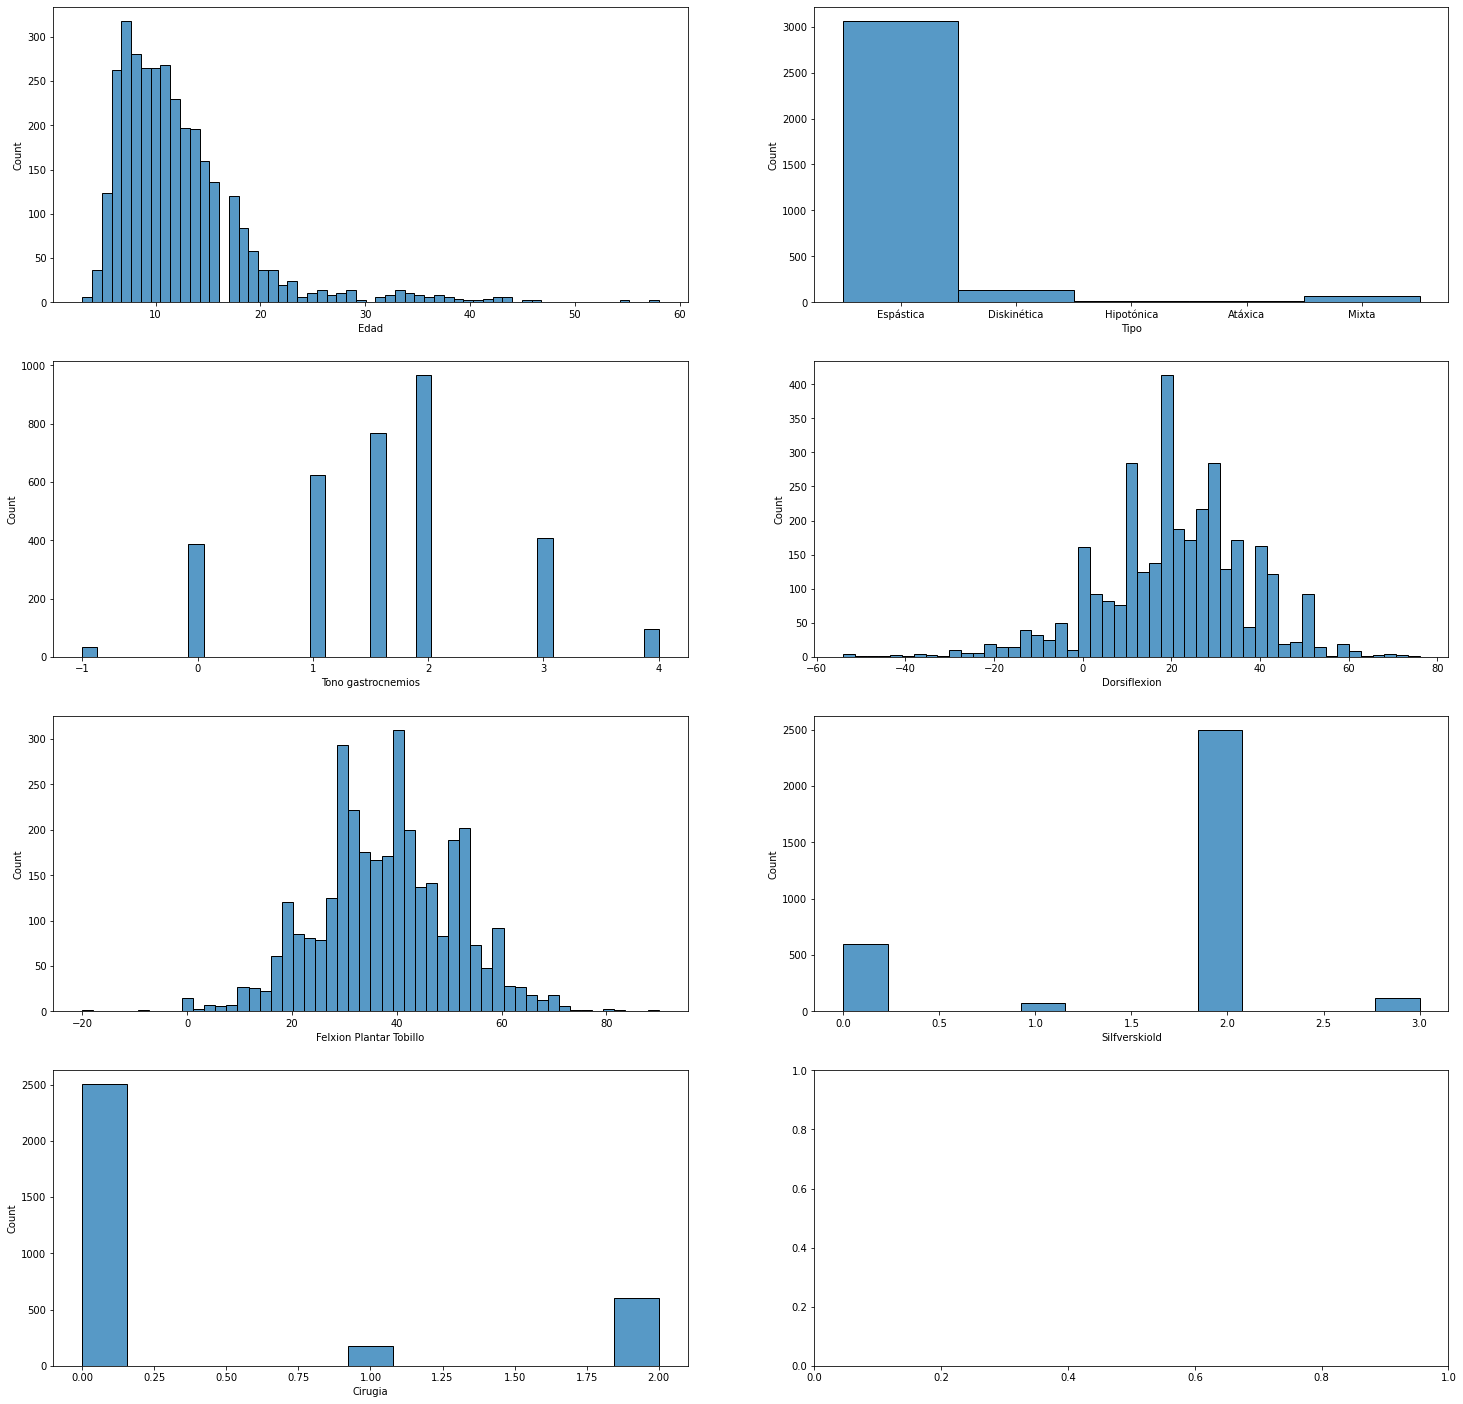

In [ ]:
from IPython.core.pylabtools import figsize
columnas=list(data_raw.columns)
fig, axs = plt.subplots(ncols=2,nrows=4, figsize=(25,25))
for i in range(0,7):
  sns.histplot(data=data_raw[columnas[i]], ax=axs[i//2][i%2])

# 3.Preparación de los datos

In [ ]:
# Se crea una copia de los datos para hacer modificaciones
data_pre=data_raw.copy()
data_pre.reset_index(inplace=True)
data_pre.drop(columns=["index"],inplace=True)

Dado que se quiere predecir si es cirugía/no cirugía, y por aparte el tipo de cirugía, se crearán una columna para este booleano.

In [ ]:
data_pre["necesitaCirugia"]=data_pre['Cirugia']!=0
data_pre['necesitaCirugia'] = data_pre['necesitaCirugia'].replace({False:0, True:1})

Además, se realizó un proceso de OneHot Encoding para convertir la variable categórica "Tipo de parálisis" en una variable numérica

In [ ]:
oneHot = OneHotEncoder()
temp=pd.DataFrame(oneHot.fit_transform(data_pre[['Tipo']]).toarray())
temp.rename(columns={0:'Ataxica',1:'Diskinetica', 2:'Espastica', 3:'Hipotonica', 4:'Mixta'},inplace=True)
data_pre=pd.concat([data_pre, temp], axis=1)
data_pre.drop(columns="Tipo", inplace=True)

In [ ]:
data_pre.head()

,Edad,Tono gastrocnemios,Dorsiflexion,Felxion Plantar Tobillo,Silfverskiold,Cirugia,necesitaCirugia,Ataxica,Diskinetica,Espastica,Hipotonica,Mixta
0,12,1.5,32,46,2,0.0,0,0.0,0.0,1.0,0.0,0.0
1,17,2.0,-6,58,2,0.0,0,0.0,0.0,1.0,0.0,0.0
2,5,4.0,10,40,2,2.0,1,0.0,0.0,1.0,0.0,0.0
3,22,1.5,0,40,2,0.0,0,0.0,0.0,1.0,0.0,0.0
4,16,1.0,40,0,2,0.0,0,0.0,0.0,1.0,0.0,0.0


Vamos a estandarizar los valores, de forma que queden en un rango similar

In [ ]:
columns = ['Edad', 'Tono gastrocnemios', 'Dorsiflexion', 'Felxion Plantar Tobillo',
       'Silfverskiold']
data_norm=data_pre.drop(columns=['Cirugia', 'necesitaCirugia', 'Ataxica', 'Diskinetica',
       'Espastica', 'Hipotonica', 'Mixta'])
scaler = StandardScaler()
data_norm = scaler.fit_transform(data_norm)
data_norm = pd.DataFrame(data_norm,columns=columns)
data_norm[['Ataxica', 'Diskinetica','Espastica', 'Hipotonica', 'Mixta']]=data_pre[['Ataxica', 'Diskinetica',
       'Espastica', 'Hipotonica', 'Mixta']]
data_norm.head()

,Edad,Tono gastrocnemios,Dorsiflexion,Felxion Plantar Tobillo,Silfverskiold,Ataxica,Diskinetica,Espastica,Hipotonica,Mixta
0,-0.027872,-0.114409,0.667573,0.600496,0.432256,0.0,0.0,1.0,0.0,0.0
1,0.736406,0.411231,-1.627285,1.533071,0.432256,0.0,0.0,1.0,0.0,0.0
2,-1.097862,2.513790,-0.661029,0.134208,0.432256,0.0,0.0,1.0,0.0,0.0
3,1.500684,-0.114409,-1.264939,0.134208,0.432256,0.0,0.0,1.0,0.0,0.0
4,0.583550,-0.640048,1.150701,-2.974375,0.432256,0.0,0.0,1.0,0.0,0.0


In [ ]:
X=data_norm.copy()
y_bool=data_pre['necesitaCirugia']
y_categ=data_pre['Cirugia']

# 4.Modelamiento

Primero, entrenaremos modelos para determinar si un paciente requiere o no cirugía.
Posteriormente, entrenaremos modelos para determinar la categoría de la cirugía, en caso de que se necesite.
Finalmente se probarán clasificadores multiclase.

In [ ]:
#@title Función para pintar matriz de confusión
# {display-mode: "form"}

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## 4.1 Clasificador binario para predecir si necesita cirugía o no

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X.drop(columns="necesitaCirugia"), y_bool, test_size=0.2, random_state=0)

In [ ]:
X_train.columns

Index(['Edad', 'Tono gastrocnemios', 'Dorsiflexion', 'Felxion Plantar Tobillo',
       'Silfverskiold', 'Ataxica', 'Diskinetica', 'Espastica', 'Hipotonica',
       'Mixta'],
      dtype='object')

### 4.1.1 Máquina de soporte vectorial

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        ('classifier', svm.SVC(C=0.1, kernel='linear', gamma='auto', class_weight='balanced'))          
    ]

parameters = {'classifier__C':[0.1, 1, 10],
              'classifier__gamma':['scale', 'auto'],
              'classifier__kernel':['linear','rbf'],
              'classifier__class_weight':[None, 'balanced']
            }

pipe_svm = Pipeline(estimators)

In [ ]:
%%time
grid_search_svm = GridSearchCV(pipe_svm, parameters, scoring='precision', cv=5, verbose = 1)
with tf.device('/device:GPU:0'):
  grid_search_svm.fit(X_train,Y_train)

In [ ]:
grid_search_svm.best_params_

{'classifier__C': 0.1,
 'classifier__class_weight': None,
 'classifier__gamma': 'auto',
 'classifier__kernel': 'rbf'}

In [ ]:
# Obtener el mejor modelo.
mejor_svm = grid_search_svm.best_estimator_

y_pred_train_svm = mejor_svm.predict(X_train)

report_svm = classification_report(Y_train, y_pred_train_svm)

print("Train Report\n", report_svm)

Train Report
               precision    recall  f1-score   support

           0       0.80      0.97      0.87      1987
           1       0.70      0.23      0.35       641

    accuracy                           0.79      2628
   macro avg       0.75      0.60      0.61      2628
weighted avg       0.77      0.79      0.75      2628



Confusion matrix, without normalization


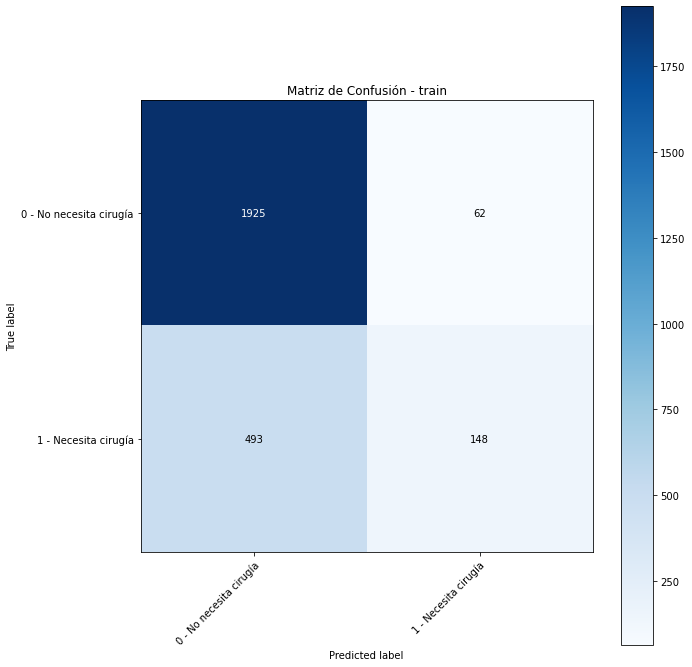

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_svm, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('classifier', svm.SVC( C=0.1,gamma="auto", kernel="rbf", class_weight=None ))]

pipe_svm_test = Pipeline(estimators)

In [ ]:
%%time
pipe_svm_test.fit(X_train, Y_train)

CPU times: user 232 ms, sys: 2.17 ms, total: 234 ms
Wall time: 242 ms


Pipeline(steps=[('classifier', SVC(C=0.1, gamma='auto'))])

In [ ]:
y_pred_test_svm=pipe_svm_test.predict(X_test)

report_tree = classification_report(Y_test, y_pred_test_svm)

print("SVM Test Report\n", report_tree)

SVM Test Report
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       514
           1       0.77      0.32      0.45       143

    accuracy                           0.83       657
   macro avg       0.80      0.65      0.68       657
weighted avg       0.82      0.83      0.80       657



Confusion matrix, without normalization


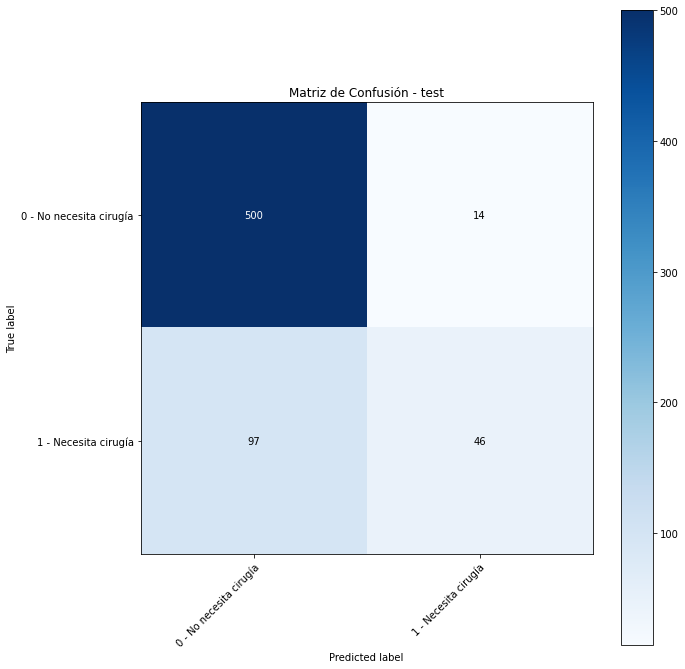

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_pred_test_svm, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - test')

### 4.1.2 KNN

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, estos no requeieren del preprocesamiento
estimators = [
        ('classifier', KNeighborsClassifier())          
    ]

parameters = {
              'classifier__weights':['distance', 'uniform'],
              'classifier__n_neighbors':[6,7,8,9,10,11,12,14,16,20,25],
              'classifier__p':[1,2],
            }

pipe_knn = Pipeline(estimators)

In [ ]:
%%time
grid_search_knn = GridSearchCV(pipe_knn, parameters, scoring='precision', cv=4, error_score=0.0)
with tf.device('/device:GPU:0'):
  grid_search_knn.fit(X_train,Y_train)

CPU times: user 6.15 s, sys: 36.4 ms, total: 6.19 s
Wall time: 6.88 s


In [ ]:
grid_search_knn.best_params_

{'classifier__n_neighbors': 20,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [ ]:
# Obtener el mejor modelo.
mejor_knn = grid_search_knn.best_estimator_

y_pred_train_knn = mejor_knn.predict(X_train)

report_tree = classification_report(Y_train, y_pred_train_knn)

print("Train Report\n", report_tree)

Train Report
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      1987
           1       0.72      0.41      0.52       641

    accuracy                           0.82      2628
   macro avg       0.77      0.68      0.70      2628
weighted avg       0.80      0.82      0.80      2628



Confusion matrix, without normalization


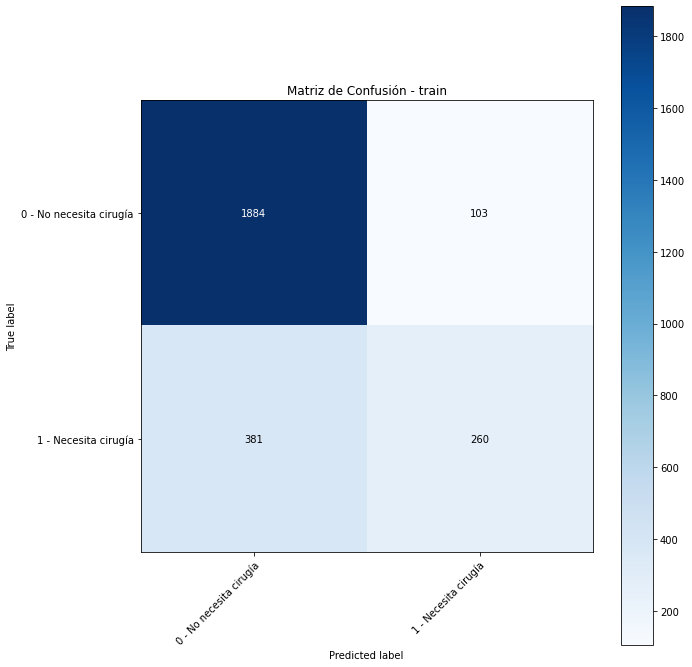

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_knn, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('classifier', KNeighborsClassifier(p=2,n_neighbors=20,weights='uniform'))]

pipe_knn_test = Pipeline(estimators)

In [ ]:
%%time
pipe_knn_test.fit(X_train, Y_train)

CPU times: user 7.1 ms, sys: 0 ns, total: 7.1 ms
Wall time: 7.5 ms


Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=20))])

In [ ]:
# y_pred_test_knn = mejor_knn.predict(X_test)
y_pred_test_knn=pipe_knn_test.predict(X_test)

report_tree = classification_report(Y_test, y_pred_test_knn)

print("KNN Test Report\n", report_tree)

KNN Test Report
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       514
           1       0.67      0.45      0.54       143

    accuracy                           0.83       657
   macro avg       0.76      0.69      0.72       657
weighted avg       0.82      0.83      0.82       657



Confusion matrix, without normalization


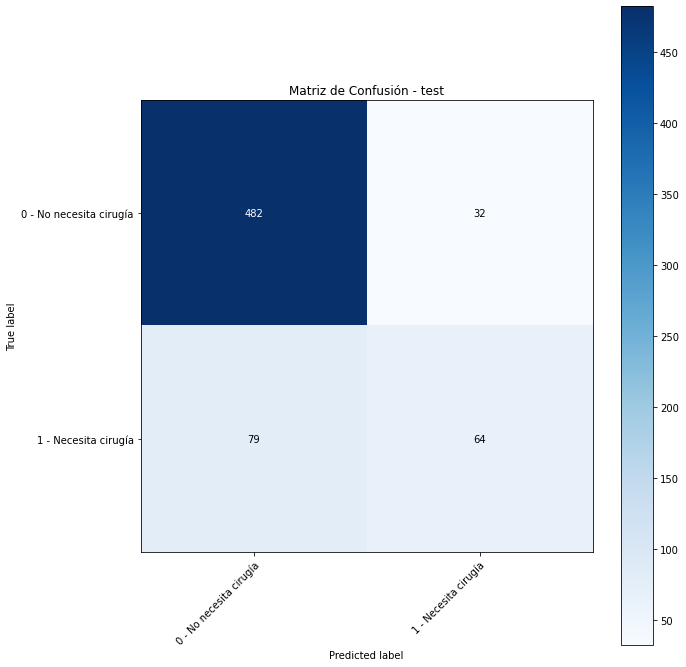

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_pred_test_knn, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - test')

### 4.1.3 Árbol de decisión

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        ('classifier', DecisionTreeClassifier(random_state=0))          
    ]

parameters = {
              'classifier__criterion':['gini','entropy'],
              'classifier__max_depth':[2,4,8,16,24,28,32],
              'classifier__min_samples_split':[2,3],
              'classifier__class_weight':[None, 'balanced']
            }

pipe_tree = Pipeline(estimators)


In [ ]:
%%time
grid_search_tree = GridSearchCV(pipe_tree, parameters, scoring='precision', cv=4, error_score=0.0)
grid_search_tree.fit(X_train,Y_train)

CPU times: user 3.19 s, sys: 14.3 ms, total: 3.2 s
Wall time: 4.19 s


In [ ]:
grid_search_tree.best_params_

{'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 4,
 'classifier__min_samples_split': 2}

In [ ]:
y_pred_train_tree = grid_search_tree.best_estimator_.predict(X_train)
report_tree = classification_report(Y_train, y_pred_train_tree)

print("Train Report\n", report_tree)

Train Report
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1987
           1       0.64      0.42      0.51       641

    accuracy                           0.80      2628
   macro avg       0.74      0.67      0.69      2628
weighted avg       0.79      0.80      0.79      2628



Confusion matrix, without normalization


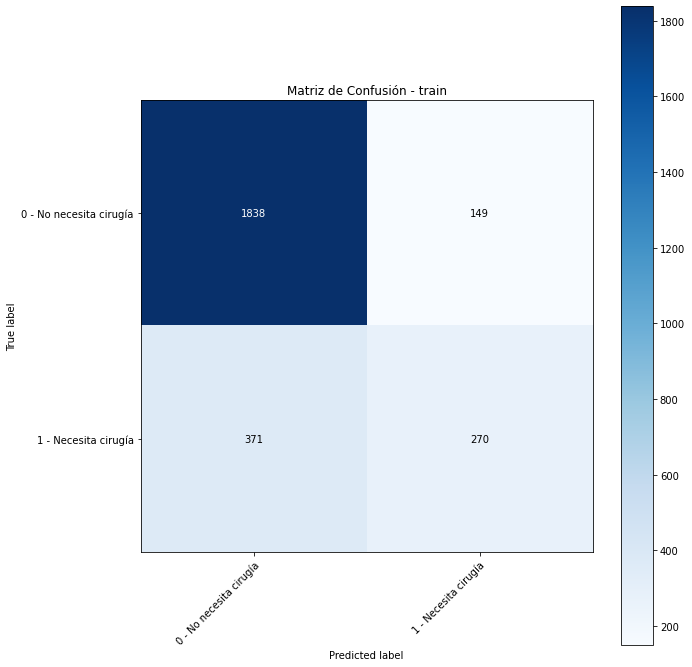

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_tree, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        
        ('classifier', DecisionTreeClassifier(criterion='entropy',max_depth=4, min_samples_split=2,random_state=0))]

pipe_tree_test = Pipeline(estimators)

In [ ]:
pipe_tree_test.fit(X_train, Y_train)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        random_state=0))])

In [ ]:
y_test_tree=pipe_tree_test.predict(X_test)

In [ ]:
report_tree_test = classification_report(Y_test, y_test_tree)

print("Tree test Report\n", report_tree_test)

Tree test Report
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       514
           1       0.62      0.48      0.54       143

    accuracy                           0.82       657
   macro avg       0.74      0.70      0.71       657
weighted avg       0.81      0.82      0.81       657



Confusion matrix, without normalization


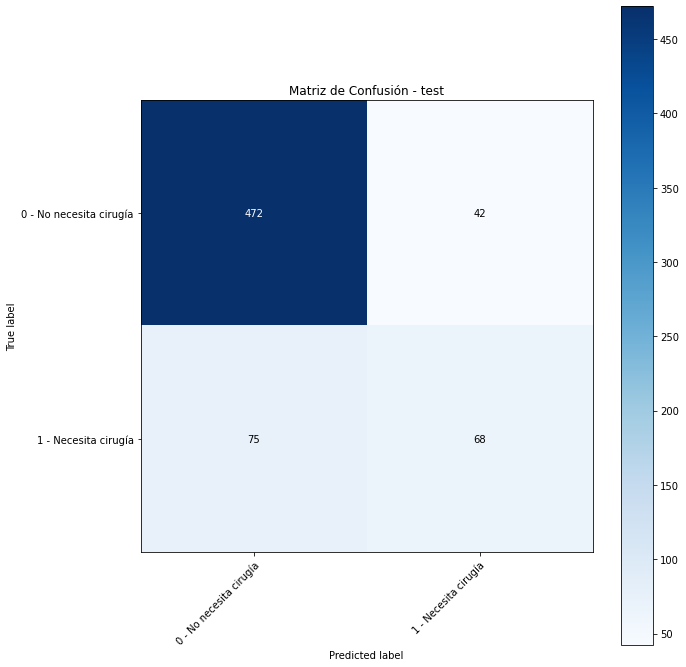

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_test_tree, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - test')

### 4.1.4 Logistic regression

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        ('classifier', LogisticRegression())          
    ]

parameters = {'classifier__penalty':['l1', 'l2', 'elasticnet', 'none'],
              'classifier__C':[0.1, 1, 10],
              'classifier__class_weight':[None, 'balanced']
              
            }

pipe_logistic = Pipeline(estimators)

In [ ]:
%%time
grid_search_logistic = GridSearchCV(pipe_logistic, parameters, scoring='precision', cv=5, verbose = 2)
with tf.device('/device:GPU:0'):
  grid_search_logistic.fit(X_train,Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.1s
[CV] END classifier_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"



[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_wei

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; tot

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__C=10, classifier__

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.

CPU times: user 3.39 s, sys: 3.66 s, total: 7.05 s
Wall time: 6.16 s


In [ ]:
grid_search_logistic.best_params_

{'classifier__C': 0.1,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2'}

In [ ]:
# Obtener el mejor modelo.
mejor_logistic = grid_search_logistic.best_estimator_

y_pred_train_logistic = mejor_logistic.predict(X_train)

report_logistic = classification_report(Y_train, y_pred_train_logistic)

print("Train Report\n", report_logistic)

Train Report
               precision    recall  f1-score   support

           0       0.81      0.95      0.88      1987
           1       0.68      0.31      0.42       641

    accuracy                           0.80      2628
   macro avg       0.75      0.63      0.65      2628
weighted avg       0.78      0.80      0.77      2628



Confusion matrix, without normalization


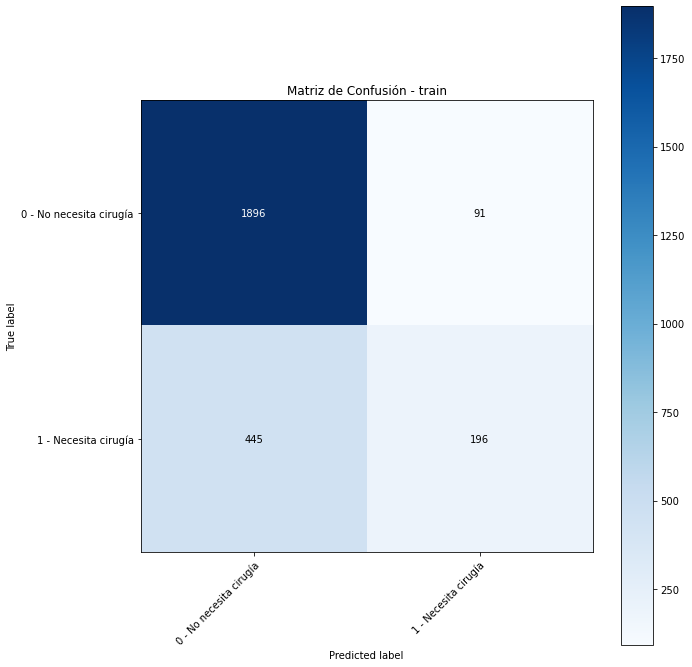

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_logistic, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('classifier', LogisticRegression( C=0.1,penalty="l2", class_weight=None ))]

pipe_logistic_test = Pipeline(estimators)

In [ ]:
%%time
pipe_logistic_test.fit(X_train, Y_train)

CPU times: user 27.2 ms, sys: 37.9 ms, total: 65.2 ms
Wall time: 58.6 ms


Pipeline(steps=[('classifier', LogisticRegression(C=0.1))])

In [ ]:
y_pred_test_logistic=pipe_logistic_test.predict(X_test)

report_tree = classification_report(Y_test, y_pred_test_logistic)

print("Logistic regression Test Report\n", report_tree)

Logistic regression Test Report
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       514
           1       0.72      0.37      0.49       143

    accuracy                           0.83       657
   macro avg       0.78      0.66      0.69       657
weighted avg       0.82      0.83      0.81       657



Confusion matrix, without normalization


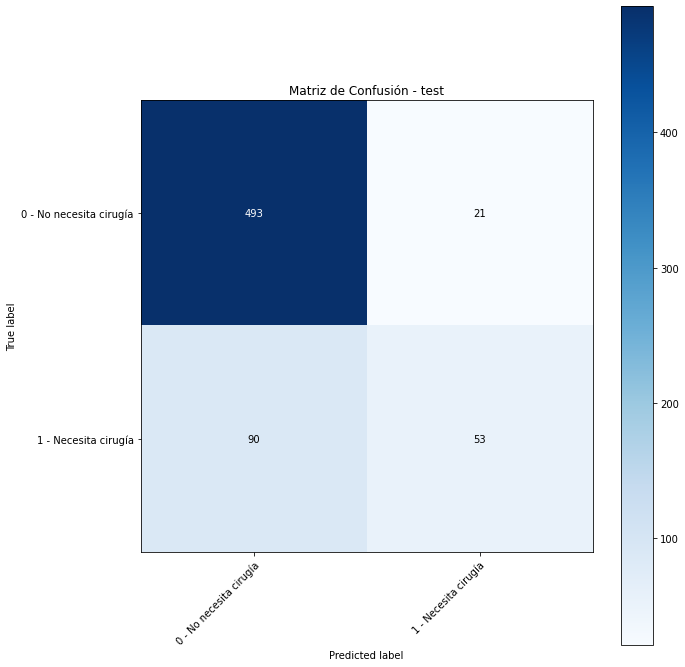

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_pred_test_logistic, classes=["0 - No necesita cirugía","1 - Necesita cirugía"],
                      title='Matriz de Confusión - test')

## 4.2 Clasificador binario para predecir el tipo de cirugía que necesita

In [ ]:
X['necesitaCirugia']=y_categ
X_class=X[ X['necesitaCirugia'] != 0 ]
X_class

,Edad,Tono gastrocnemios,Dorsiflexion,Felxion Plantar Tobillo,Silfverskiold,Ataxica,Diskinetica,Espastica,Hipotonica,Mixta,necesitaCirugia
2,-1.097862,2.513790,-0.661029,0.134208,0.432256,0.0,0.0,1.0,0.0,0.0,2.0
5,0.430695,1.462510,-1.264939,0.134208,0.432256,0.0,0.0,1.0,0.0,0.0,2.0
6,0.124983,-1.691328,-3.318233,2.154788,1.660596,0.0,0.0,1.0,0.0,0.0,1.0
8,-0.027872,1.462510,-1.748067,1.377642,0.432256,0.0,0.0,1.0,0.0,0.0,1.0
9,-0.333584,0.411231,-1.264939,2.154788,0.432256,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3241,-0.792151,-0.114409,-1.989631,1.688500,0.432256,0.0,0.0,1.0,0.0,0.0,1.0
3246,-0.639295,0.411231,-1.506503,1.688500,0.432256,0.0,0.0,1.0,0.0,0.0,1.0
3254,-0.027872,-0.114409,-1.989631,2.310217,0.432256,0.0,0.0,1.0,0.0,0.0,1.0
3258,2.112107,0.411231,-1.627285,1.066784,0.432256,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X_class.drop(columns='necesitaCirugia'), X_class['necesitaCirugia'], test_size=0.2, random_state=0)

### 4.2.1 Máquina de soporte vectorial

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        ('classifier', svm.SVC(C=0.1, kernel='linear', gamma='auto', class_weight='balanced'))          
    ]

parameters = {'classifier__C':[0.1, 1, 10],
              'classifier__gamma':['scale', 'auto'],
              'classifier__kernel':['linear','rbf'],
              'classifier__class_weight':[None, 'balanced']
            }

pipe_svm = Pipeline(estimators)

In [ ]:
%%time
grid_search_svm = GridSearchCV(pipe_svm, parameters, scoring='accuracy', cv=5, verbose = 2)
with tf.device('/device:GPU:0'):
  grid_search_svm.fit(X_train,Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__gamma=scale, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.1, classi

In [ ]:
grid_search_svm.best_params_

{'classifier__C': 10,
 'classifier__class_weight': None,
 'classifier__gamma': 'auto',
 'classifier__kernel': 'rbf'}

In [ ]:
# Obtener el mejor modelo.
mejor_svm = grid_search_svm.best_estimator_

y_pred_train_svm = mejor_svm.predict(X_train)

report_svm = classification_report(Y_train, y_pred_train_svm)

print("Train Report\n", report_svm)

Train Report
               precision    recall  f1-score   support

         1.0       0.80      0.56      0.66       139
         2.0       0.88      0.96      0.92       488

    accuracy                           0.87       627
   macro avg       0.84      0.76      0.79       627
weighted avg       0.87      0.87      0.86       627



Confusion matrix, without normalization


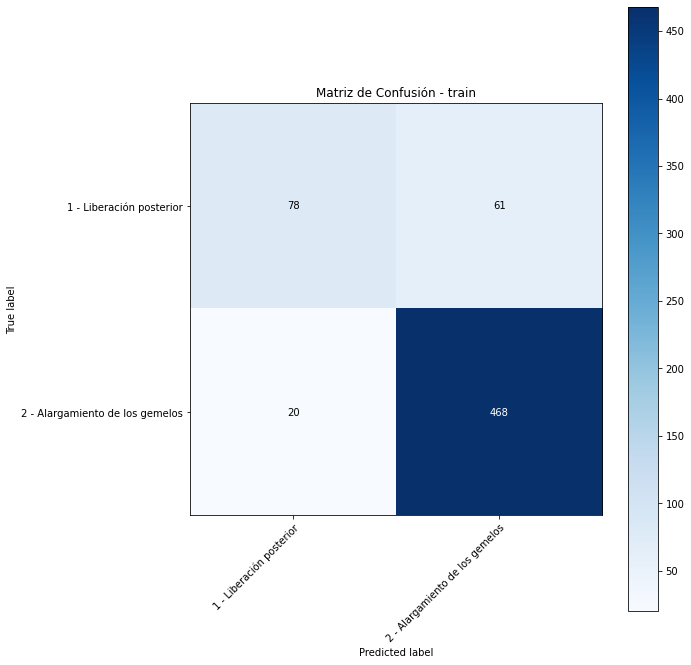

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_svm, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('classifier', svm.SVC( C=10,gamma="auto", kernel="rbf", class_weight=None ))]

pipe_svm_test = Pipeline(estimators)

In [ ]:
%%time
pipe_svm_test.fit(X_train, Y_train)

CPU times: user 30.1 ms, sys: 0 ns, total: 30.1 ms
Wall time: 39.1 ms


Pipeline(steps=[('classifier', SVC(C=10, gamma='auto'))])

In [ ]:
y_pred_test_svm=pipe_svm_test.predict(X_test)

report_tree = classification_report(Y_test, y_pred_test_svm)

print("SVM Test Report\n", report_tree)

SVM Test Report
               precision    recall  f1-score   support

         1.0       0.84      0.40      0.54        40
         2.0       0.83      0.97      0.89       117

    accuracy                           0.83       157
   macro avg       0.83      0.69      0.72       157
weighted avg       0.83      0.83      0.80       157



Confusion matrix, without normalization


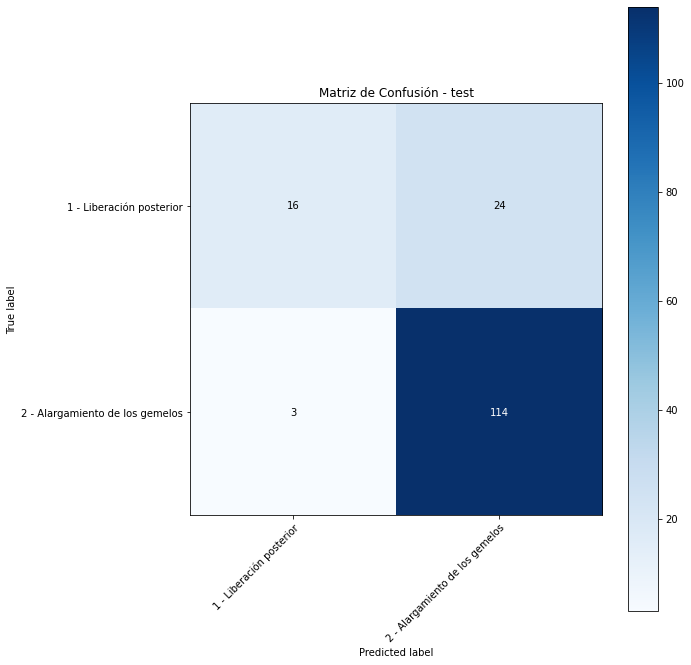

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_pred_test_svm, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - test')

### 4.2.2 KNN

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, estos no requeieren del preprocesamiento
estimators = [
        ('classifier', KNeighborsClassifier())          
    ]

parameters = {
              'classifier__weights':['distance', 'uniform'],
              'classifier__n_neighbors':[6,7,8,9,10,11,12,14,16,20,25],
              'classifier__p':[1,2],
            }

pipe_knn = Pipeline(estimators)

In [ ]:
%%time
grid_search_knn = GridSearchCV(pipe_knn, parameters, scoring='accuracy', cv=4, error_score=0.0)
with tf.device('/device:GPU:0'):
  grid_search_knn.fit(X_train,Y_train)

CPU times: user 1.76 s, sys: 7.06 ms, total: 1.76 s
Wall time: 1.78 s


In [ ]:
grid_search_knn.best_params_

{'classifier__n_neighbors': 25,
 'classifier__p': 1,
 'classifier__weights': 'uniform'}

In [ ]:
# Obtener el mejor modelo.
mejor_knn = grid_search_knn.best_estimator_

y_pred_train_knn = mejor_knn.predict(X_train)

report_tree = classification_report(Y_train, y_pred_train_knn)

print("Train Report\n", report_tree)

Train Report
               precision    recall  f1-score   support

         1.0       0.77      0.45      0.57       139
         2.0       0.86      0.96      0.91       488

    accuracy                           0.85       627
   macro avg       0.81      0.71      0.74       627
weighted avg       0.84      0.85      0.83       627



Confusion matrix, without normalization


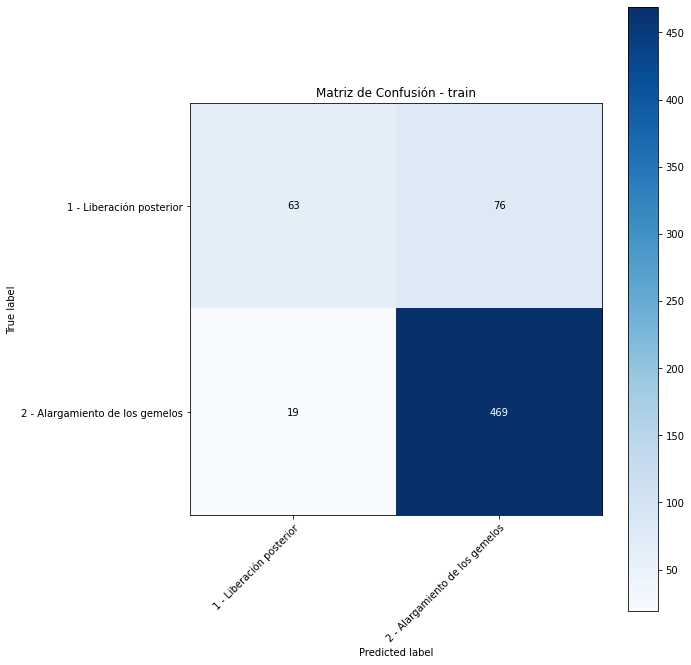

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_knn, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('classifier', KNeighborsClassifier(p=1,n_neighbors=25,weights='uniform'))]

pipe_knn_test = Pipeline(estimators)

In [ ]:
%%time
pipe_knn_test.fit(X_train, Y_train)

CPU times: user 5.24 ms, sys: 2.91 ms, total: 8.14 ms
Wall time: 8.28 ms


Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=25, p=1))])

In [ ]:
# y_pred_test_knn = mejor_knn.predict(X_test)
y_pred_test_knn=pipe_knn_test.predict(X_test)

report_tree = classification_report(Y_test, y_pred_test_knn)

print("KNN Test Report\n", report_tree)

KNN Test Report
               precision    recall  f1-score   support

         1.0       0.76      0.40      0.52        40
         2.0       0.82      0.96      0.89       117

    accuracy                           0.82       157
   macro avg       0.79      0.68      0.70       157
weighted avg       0.81      0.82      0.79       157



Confusion matrix, without normalization


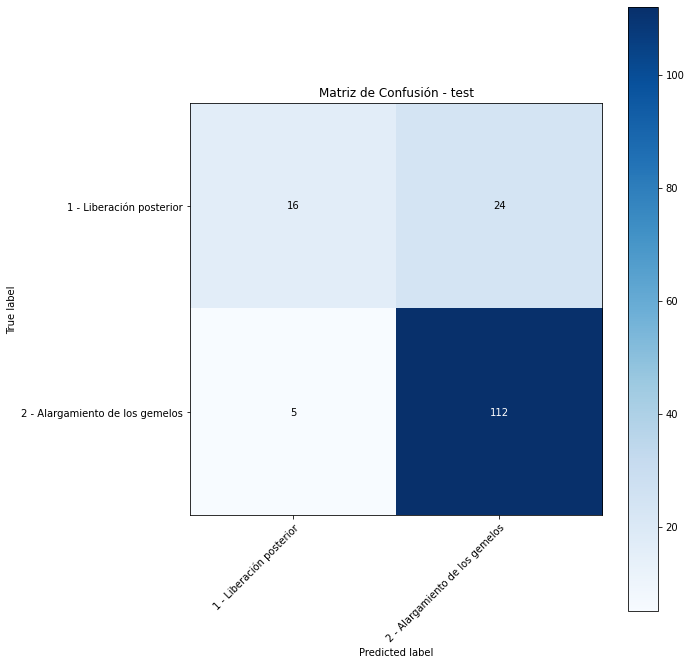

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_pred_test_knn, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - test')

### 4.2.3 Árbol de decisión

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        ('classifier', DecisionTreeClassifier(random_state=0))          
    ]

parameters = {
              'classifier__criterion':['gini','entropy'],
              'classifier__max_depth':[2,4,8,16,24,28,32],
              'classifier__min_samples_split':[2,3],
              'classifier__class_weight':[None, 'balanced']
            }

pipe_tree = Pipeline(estimators)


In [ ]:
%%time
grid_search_tree = GridSearchCV(pipe_tree, parameters, scoring='accuracy', cv=4, error_score=0.0)
grid_search_tree.fit(X_train,Y_train)

CPU times: user 1.44 s, sys: 10.3 ms, total: 1.45 s
Wall time: 1.46 s


In [ ]:
grid_search_tree.best_params_

{'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 2,
 'classifier__min_samples_split': 2}

In [ ]:
y_pred_train_tree = grid_search_tree.best_estimator_.predict(X_train)
report_tree = classification_report(Y_train, y_pred_train_tree)

print("Train Report\n", report_tree)

Train Report
               precision    recall  f1-score   support

         1.0       0.68      0.63      0.65       139
         2.0       0.90      0.92      0.91       488

    accuracy                           0.85       627
   macro avg       0.79      0.77      0.78       627
weighted avg       0.85      0.85      0.85       627



Confusion matrix, without normalization


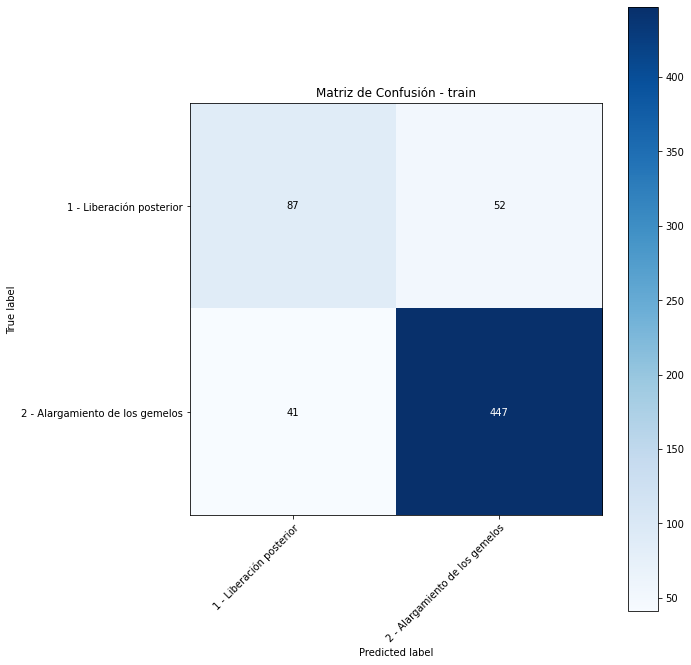

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_tree, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        
        ('classifier', DecisionTreeClassifier(criterion='gini',max_depth=2, min_samples_split=2,random_state=0))]

pipe_tree_test = Pipeline(estimators)

In [ ]:
pipe_tree_test.fit(X_train, Y_train)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=2, random_state=0))])

In [ ]:
y_test_tree=pipe_tree_test.predict(X_test)

In [ ]:
report_tree_test = classification_report(Y_test, y_test_tree)

print("Tree test Report\n", report_tree_test)

Tree test Report
               precision    recall  f1-score   support

         1.0       0.67      0.60      0.63        40
         2.0       0.87      0.90      0.88       117

    accuracy                           0.82       157
   macro avg       0.77      0.75      0.76       157
weighted avg       0.82      0.82      0.82       157



Confusion matrix, without normalization


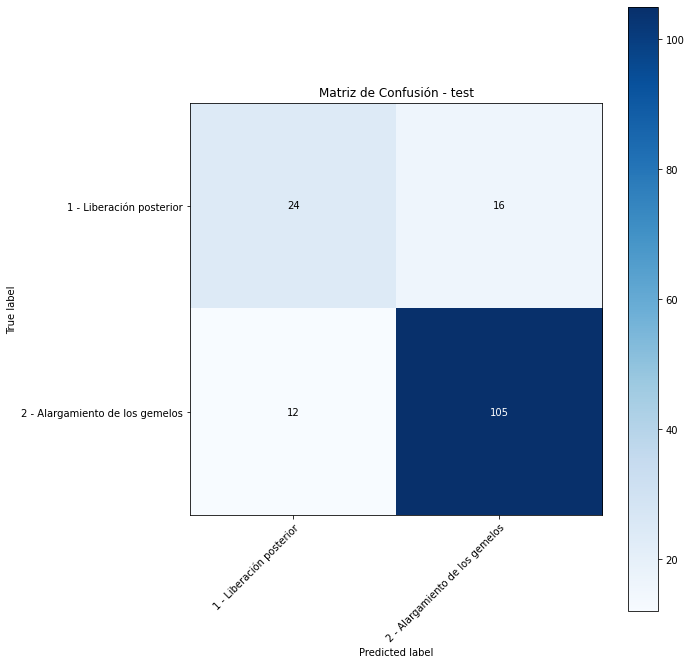

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_test_tree, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - test')

### 4.2.4 Logistic regression

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        ('classifier', LogisticRegression())          
    ]

parameters = {'classifier__penalty':['l1', 'l2', 'elasticnet', 'none'],
              'classifier__C':[0.1, 1, 10],
              'classifier__class_weight':[None, 'balanced']
              
            }

pipe_logistic = Pipeline(estimators)

In [ ]:
%%time
grid_search_logistic = GridSearchCV(pipe_logistic, parameters, scoring='accuracy', cv=5, verbose = 2)
with tf.device('/device:GPU:0'):
  grid_search_logistic.fit(X_train,Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__C=0.1, classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=elasticnet; total time=   0.0s
[CV] END classifier__C=1, classifier__class_weight=None, classifier__penalty=elasticnet; tot

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=None, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.0s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balance

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.1s
[CV] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=none; total time=   0.0s
CPU times: user 1.47 s, sys: 44.2 ms, total: 1.51 s
Wall time: 2 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.

In [ ]:
grid_search_logistic.best_params_

{'classifier__C': 10,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2'}

In [ ]:
# Obtener el mejor modelo.
mejor_logistic = grid_search_logistic.best_estimator_

y_pred_train_logistic = mejor_logistic.predict(X_train)

report_logistic = classification_report(Y_train, y_pred_train_logistic)

print("Train Report\n", report_logistic)

Train Report
               precision    recall  f1-score   support

         1.0       0.74      0.55      0.63       139
         2.0       0.88      0.94      0.91       488

    accuracy                           0.86       627
   macro avg       0.81      0.75      0.77       627
weighted avg       0.85      0.86      0.85       627



Confusion matrix, without normalization


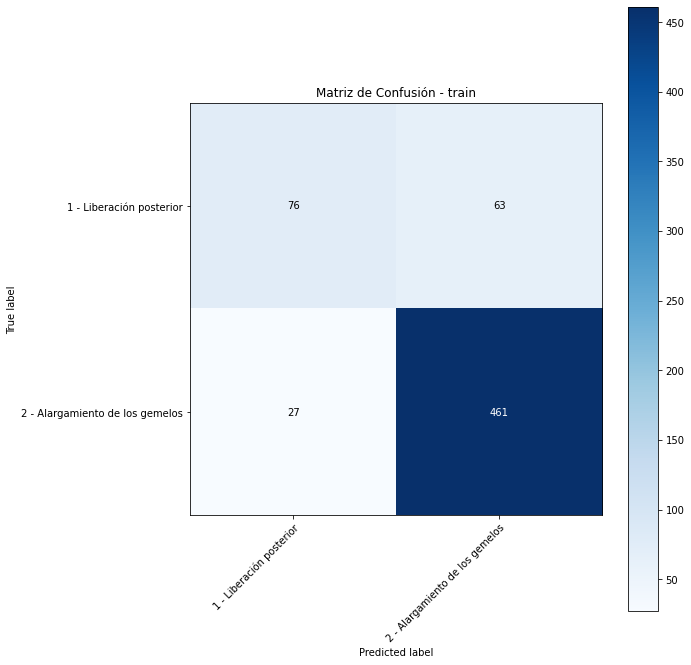

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred_train_logistic, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('classifier', LogisticRegression( C=10,penalty="l2", class_weight=None ))]

pipe_logistic_test = Pipeline(estimators)

In [ ]:
%%time
pipe_logistic_test.fit(X_train, Y_train)

CPU times: user 25.6 ms, sys: 888 µs, total: 26.5 ms
Wall time: 44.4 ms


Pipeline(steps=[('classifier', LogisticRegression(C=10))])

In [ ]:
y_pred_test_logistic=pipe_logistic_test.predict(X_test)

report_tree = classification_report(Y_test, y_pred_test_logistic)

print("Logistic regression Test Report\n", report_tree)

Logistic regression Test Report
               precision    recall  f1-score   support

         1.0       0.77      0.50      0.61        40
         2.0       0.85      0.95      0.90       117

    accuracy                           0.83       157
   macro avg       0.81      0.72      0.75       157
weighted avg       0.83      0.83      0.82       157



Confusion matrix, without normalization


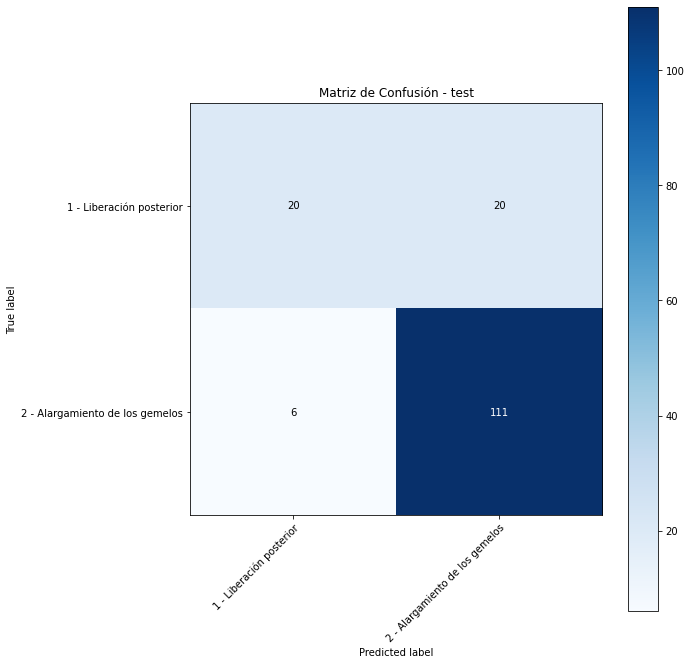

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=Y_test, y_pred=y_pred_test_logistic, classes=["1 - Liberación posterior","2 - Alargamiento de los gemelos"],
                      title='Matriz de Confusión - test')

# 5.Exportar el modelo

In [ ]:
example={"Edad":[-0.027872],"Tono gastrocnemios":[ -0.114409], "Dorsiflexion":	[0.667573],"Felxion Plantar Tobillo":[0.600496],"Silfverskiold":[0.432256],"Ataxica":[0.0],	"Diskinetica":[0.0],"Espastica":[1.0],	"Hipotonica":[0.0],"Mixta":[0.0]}
input=pd.DataFrame.from_dict(example)

In [ ]:
columns = ['Edad', 'Tono gastrocnemios', 'Dorsiflexion', 'Felxion Plantar Tobillo',       'Silfverskiold']
input[columns]

,Edad,Tono gastrocnemios,Dorsiflexion,Felxion Plantar Tobillo,Silfverskiold
0,-0.027872,-0.114409,0.667573,0.600496,0.432256


In [ ]:
pipe_knn_test.predict(input)

array([0])

In [ ]:
pipe_svm_test.predict(input)

array([2.])

In [ ]:
# Usamos la lbreria joblib
filename = 'knn_si_no.joblib'
# Se guarda
dump(pipe_knn_test, filename) 

['knn_si_no.joblib']

In [ ]:
# Usamos la lbreria joblib
filename = 'svm_cirugia.joblib'
# Se guarda
dump(pipe_svm_test, filename) 

['svm_cirugia.joblib']

In [ ]:
# Usamos la lbreria joblib
filename = 'scaler.joblib'
# Se guarda
dump(scaler, filename) 

['scaler.joblib']

In [ ]:
a=scaler.transform(input[columns])
a

array([[-1.86640073, -1.81160356, -1.22462326, -2.92770769, -1.49346619]])

# 6.A futuro

Light Gradient Boosting Machine
Random Forest

SMOTE
Undersampling
